# Description

A simple model that predicts which stock in a pair will have higher return on
the next day.


# Versions
## v1
- Context window: 8 days price history
- Logistic model predicts which stock has higher return on the next day
- Naive strategy of holding the stock with predicted higher return
- Table comparing return vs baselines: always hold either stock in the pair

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline

import pandas as pd
import torch as th
import numpy as np

plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

# Dataset

In [3]:
from data import daily_df
from data import date_range

batch_size = 128
hist_win = 8

train_date_range = date_range.DateRange('2003-01-01', '2017-01-01')
eval_date_range = date_range.DateRange('2017-01-01', '2020-01-01')

In [4]:
tickers = ('GOOG', 'AAPL', 'MSFT', 'SPY', 'SHY')
num_tickers = len(tickers)

def load_df(tickers, date_range):
  cfg = daily_df.Cfg(tickers=tickers)
  df = daily_df.load_df(cfg, date_range)
  print(f'Loaded {len(df)} days.')
  df = df.dropna(how='any').reset_index(drop=True)
  print(f'Kept {len(df)} days.')
  return df

df_train = load_df(tickers, train_date_range)
df_valid = load_df(tickers, eval_date_range)

Loaded 3525 days.
Kept 3115 days.
Loaded 754 days.
Kept 754 days.


In [5]:
df_train.head(5)

,date,GOOG_volume,GOOG_open,GOOG_high,GOOG_low,GOOG_close,GOOG_adjclose,AAPL_volume,AAPL_open,AAPL_high,...,SPY_high,SPY_low,SPY_close,SPY_adjclose,SHY_volume,SHY_open,SHY_high,SHY_low,SHY_close,SHY_adjclose
0,2004-08-19,44871300.0,49.813286,51.835709,47.800831,49.982655,49.982655,97230000,2.250714,2.275714,...,110.019997,109.180000,109.709999,79.441208,265400,82.080002,82.169998,82.080002,82.169998,62.261700
1,2004-08-20,22942800.0,50.316402,54.336334,50.062355,53.952770,53.952770,79195200,2.193571,2.213571,...,110.629997,109.510002,110.480003,79.998734,132500,82.160004,82.169998,82.089996,82.120003,62.223801
2,2004-08-23,18342800.0,55.168217,56.528118,54.321388,54.495735,54.495735,63665000,2.204286,2.233572,...,110.769997,110.050003,110.199997,79.795982,98600,82.080002,82.080002,82.040001,82.050003,62.170788
3,2004-08-24,15319700.0,55.412300,55.591629,51.591621,52.239193,52.239193,93534000,2.232857,2.282143,...,110.730003,109.849998,110.349998,79.904640,188000,82.040001,82.089996,81.989998,82.089996,62.201096
4,2004-08-25,9232100.0,52.284027,53.798351,51.746044,52.802086,52.802086,126404600,2.276428,2.367857,...,111.269997,109.900002,111.099998,80.447693,114800,82.110001,82.139999,82.029999,82.059998,62.178356


In [6]:
df_train.tail(5)

,date,GOOG_volume,GOOG_open,GOOG_high,GOOG_low,GOOG_close,GOOG_adjclose,AAPL_volume,AAPL_open,AAPL_high,...,SPY_high,SPY_low,SPY_close,SPY_adjclose,SHY_volume,SHY_open,SHY_high,SHY_low,SHY_close,SHY_adjclose
3110,2016-12-23,623400.0,790.900024,792.739990,787.280029,789.909973,789.909973,14249500,115.589996,116.519997,...,225.720001,225.210007,225.710007,211.065186,1058500,84.339996,84.339996,84.320000,84.339996,79.836014
3111,2016-12-27,789100.0,790.679993,797.859985,787.656982,791.549988,791.549988,18296900,116.519997,117.800003,...,226.729996,226.000000,226.270004,211.588837,893600,84.290001,84.309998,84.279999,84.300003,79.798157
3112,2016-12-28,1153800.0,793.700012,794.229980,783.200012,785.049988,785.049988,20905900,117.519997,118.019997,...,226.589996,224.270004,224.399994,209.840149,1312300,84.300003,84.349998,84.279999,84.330002,79.826523
3113,2016-12-29,744300.0,783.330017,785.929993,778.919983,782.789978,782.789978,15039500,116.449997,117.110001,...,224.889999,223.839996,224.350006,209.793396,1274800,84.360001,84.419998,84.349998,84.419998,79.911705
3114,2016-12-30,1770000.0,782.750000,782.780029,770.409973,771.820007,771.820007,30586300,116.650002,117.199997,...,224.830002,222.729996,223.529999,209.026611,1214600,84.430000,84.459999,84.419998,84.449997,79.940155


In [7]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

from data import daily_dataset

PRICE_REPR = daily_dataset.PriceRepr.RETURN

def create_ds_dl(df, tickers, price_repr=PRICE_REPR):
  ds = daily_dataset.StockSeqDataset(
    df=df,
    cols=[f'{ticker}_adjclose' for ticker in tickers],
    window_size=hist_win + 1,
    price_repr=price_repr)

  ds_multistock = daily_dataset.MultiStockSelectionDataset(ds)
  dl_multistock = DataLoader(dataset=ds_multistock, batch_size=batch_size,
                            shuffle=True)
  return ds_multistock, dl_multistock

ds_train, dl_train = create_ds_dl(df_train, tickers)
ds_valid, dl_valid = create_ds_dl(df_valid, tickers)

In [8]:
print(len(ds_train), len(dl_train))
print(len(ds_valid), len(dl_valid))

3106 25
745 6


In [9]:
ds_train[0]

{'x': tensor([[1.0794, 1.0029, 1.0030, 1.0070, 0.9994],
         [1.0101, 1.0091, 1.0044, 0.9975, 0.9991],
         [0.9586, 1.0280, 1.0000, 1.0014, 1.0005],
         [1.0108, 1.0344, 1.0114, 1.0068, 0.9996],
         [1.0180, 1.0487, 0.9960, 1.0000, 1.0010],
         [0.9837, 0.9911, 1.0007, 1.0032, 0.9996],
         [0.9610, 0.9933, 0.9942, 0.9917, 1.0002],
         [1.0035, 1.0108, 1.0000, 1.0052, 1.0015]]),
 'y': tensor([0.9793, 1.0397, 1.0033, 1.0019, 1.0003]),
 'label': tensor(1)}

In [10]:
for batch in dl_train:
    print({k: t.shape for k, t in batch.items()})
    break

{'x': torch.Size([128, 8, 5]), 'y': torch.Size([128, 5]), 'label': torch.Size([128])}


# Model

In [11]:
class MultiStockSelector(th.nn.Module):
  def __init__(self, num_tickers, hist_win):
    super().__init__()
    self.ff = th.nn.Sequential(
      th.nn.LayerNorm(num_tickers * hist_win),
      th.nn.Linear(num_tickers * hist_win, 1000),
      th.nn.Sigmoid(),
      th.nn.Linear(1000, 1000),
      th.nn.Sigmoid(),
      th.nn.Linear(1000, num_tickers),
    )
    self.apply(self.init_)

  def init_(self, m):
    if isinstance(m, th.nn.Linear):
      th.nn.init.xavier_normal_(m.weight)
      th.nn.init.constant_(m.bias, 0.0)
    
  def forward(self, x):
    x = x.view(x.shape[0], -1)  # [b, t * n_tickers]
    logits = self.ff(x)
    return logits
    

model = MultiStockSelector(num_tickers=num_tickers, hist_win=hist_win)
loss_fn = th.nn.CrossEntropyLoss()

learning_rate = 3e-4
optimizer = th.optim.Adam(model.parameters(), lr=learning_rate)
lr_schedule = th.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)


def eval(model, dl):
  model.eval()
  with th.no_grad():
    loss_avg = 0
    epoch_accuracy = 0
    assert PRICE_REPR == daily_dataset.PriceRepr.RETURN
    log_return = 0
    base_log_return = [0] * num_tickers
    oracle_log_return = 0
    for batch in dl:
        x = batch['x']
        label = batch['label']
        logits = model(x)
        loss = loss_fn(logits, label)
        loss_avg += loss.item()
        preds = th.argmax(logits, axis=-1)
        accuracy = (label == preds).sum().item() / label.shape[0]
        epoch_accuracy += accuracy
        y = batch['y']
        day_return = y[np.arange(y.shape[0]), preds]
        log_return += day_return.log().sum()
        for i in range(num_tickers):
          ret = y[:, i]
          base_log_return[i] += ret.log().sum()
        oracle = y.max(dim=-1)[0]
        oracle_log_return += oracle.log().sum()
    print(f'valid loss: {loss_avg / len(dl):.4f}; '
          f'accuracy: {100 * epoch_accuracy / len(dl):.2f}%; '
          f'total_return: {log_return.exp():.2f}; ' +
          ''.join(
            f'{tickers[i]}_return: {base_log_return[i].exp():.2f}; '
            for i in range(num_tickers)
          ) +
          f'oracle_return: {oracle_log_return.exp():.2f}; '
    )
  model.train()


epochs = 100
for epoch in range(epochs):
    loss_avg = 0
    epoch_accuracy = 0
    log_return = 0
    for batch in dl_train:
        x = batch['x']
        label = batch['label']
        logits = model(x)
        loss = loss_fn(logits, label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_avg += loss.item()
        preds = th.argmax(logits, axis=-1)
        accuracy = (label == preds).sum().item() / label.shape[0]
        epoch_accuracy += accuracy
    lr_schedule.step()
    print(f'epoch: {epoch}; '
          f'lr: {lr_schedule.get_last_lr()[0]:.5f}; '
          f'train loss: {loss_avg / len(dl_train):.4f}; '
          f'accuracy: {100 * epoch_accuracy / len(dl_train):.2f}%; ')
    eval(model, dl_train)
    eval(model, dl_valid)

In [ ]:
model(x).max(dim=-1)

torch.return_types.max(
values=tensor([0.6818, 0.7402, 0.7564, 0.5901, 0.6439, 0.9321, 0.6633, 0.5246, 0.7731,
        0.8557, 0.6246, 0.8806, 0.4194, 0.8496, 0.5779, 0.5793, 0.9436, 0.5936,
        0.6955, 0.6448, 0.7134, 0.6458, 0.6085, 0.5632, 0.7114, 0.8960, 0.8771,
        0.5177, 0.7053, 0.5698, 0.5644, 0.7014, 0.5656, 0.7765],
       grad_fn=<MaxBackward0>),
indices=tensor([1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

# Baseline Models

In [ ]:
class MeanModel(th.nn.Module):
    def forward(self, x):
        return x.mean(dim=-1).unsqueeze(axis=1)

# Validation

In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([1.0115, 1.0164, 1.0062, 1.0045, 1.0370, 1.0106, 1.0099, 1.0121, 0.9970,
         1.0348, 1.0099, 1.0165, 1.0298, 1.0120, 1.0209, 1.0246, 1.0008, 1.0222,
         1.0131, 1.0323, 1.0095, 1.0257, 1.0284, 1.0164, 1.0252, 1.0231, 1.0063,
         0.9980, 1.0100, 1.0305, 1.0015, 1.0171, 1.0143, 1.0246, 1.0227, 1.0208,
         1.0158, 1.0210, 1.0205, 1.0292], requires_grad=True),
 Parameter containing:
 tensor([ 1.5849e-03, -2.9011e-03,  2.8525e-03,  8.0630e-04, -5.4493e-04,
          5.0658e-04, -2.1220e-03,  1.7511e-03, -1.4074e-03, -1.1451e-03,
          3.6636e-03,  8.7178e-04,  6.0448e-04, -1.0761e-04,  1.7974e-03,
         -1.2441e-03, -1.8527e-03,  4.1831e-04,  3.4454e-04,  3.4687e-04,
          9.4529e-04,  1.9511e-04, -1.8231e-03,  1.5971e-03, -3.4989e-05,
         -6.5905e-04, -2.9057e-03, -2.7462e-04, -2.3975e-03,  2.7428e-03,
         -1.3379e-03,  1.6393e-04, -2.5051e-03,  5.7792e-04, -1.5172e-03,
         -2.2976e-03,  2.1151e-03,  2.2742e-03, -

In [ ]:
def validate(model, ticker):
  assert pred_win == 1
  df = load_df(ticker, eval_date_range)
  ds = StockSeqDataset(df)
  dl = DataLoader(dataset=ds, batch_size=batch_size, shuffle=False)
  for i, (x, y) in enumerate(dl):
    start = batch_size * i + hist_win  # prediction is offset by hist_win
    end = start + batch_size - 1  # slice end is inclusive
    with th.no_grad():
      y_pred = model(x)
    y = y.cpu().numpy().squeeze()
    y_pred = y_pred.cpu().numpy().squeeze()
    #import pdb; pdb.set_trace()
    df.loc[start:end, 'actual'] = y
    df.loc[start:end, 'pred'] = y_pred
  return df

def plot(df, cols=['actual', 'pred']):
 df.plot(x='date', y=cols, figsize=(10, 8))

In [ ]:
df_pred = validate(model, 'FB')
plot(df_pred)

NameError: name 'pred_win' is not defined

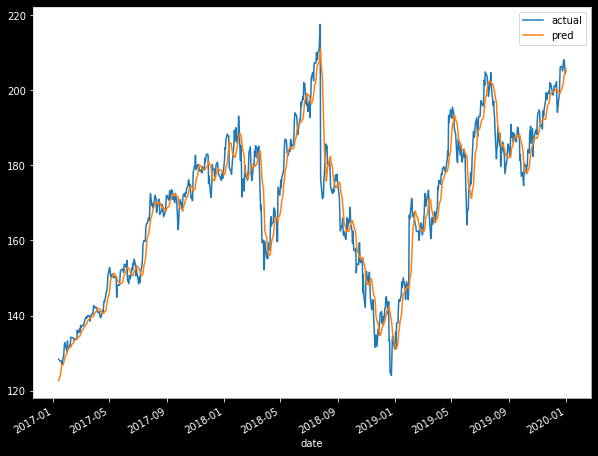

In [ ]:
df_pred = validate(MeanModel(), 'FB')
plot(df_pred)

# Strategy

In [ ]:
class SimpleStrategy:
  """Simple strategy

  If day's predicted change is positive, hold through day.
  If day's predicted change is negative, skip the day.
  """
  def __init__(self, model):
    self.model = model

  def compute_hold(self, ticker):
    df_pred = validate(self.model, ticker)
    df_pred = df_pred.dropna(subset=('actual', 'pred'))
    actual, pred = df_pred['actual'].values, df_pred['pred'].values
    assert len(actual) == len(pred)
    hold = pred[1:] > pred[:-1]
    return pd.DataFrame.from_dict({
        'actual': actual[1:],
        'pred': pred[1:],
        'hold': hold,
    })

def compute_returns(df):
  df = df.copy()
  df.loc[:, 'roi_actual'] = df.actual / df.actual.shift(1)
  df.loc[:, 'roi_pred'] = df.pred / df.pred.shift(1)
  return df

def total_return(df, query=None):
  if query:
    df = df.query(query)
  roi_actual = df.roi_actual.product()
  roi_pred = df.roi_pred.product()
  return roi_actual, roi_pred

def evaluate_models(models, tickers):
  strats = {name: SimpleStrategy(model) for name, model in models.items()}
  df_actual = pd.DataFrame()
  df_pred = pd.DataFrame()
  
  for ticker in tickers:
    for strat_name, strat in strats.items():
      df_hold = strat.compute_hold(ticker)
      df_roi = compute_returns(df_hold)
      
      all = total_return(df_roi)
      hold = total_return(df_roi, 'hold == True')
      not_hold = total_return(df_roi, 'hold == False')

      df_actual.loc[strat_name + ': all', ticker] = all[0]
      df_actual.loc[strat_name + ': hold', ticker] = hold[0]
      df_actual.loc[strat_name + ': !hold', ticker] = not_hold[0]
      df_pred.loc[strat_name + ': all', ticker] = all[1]
      df_pred.loc[strat_name + ': hold', ticker] = hold[1]
      df_pred.loc[strat_name + ': !hold', ticker] = not_hold[1]
  return df_actual, df_pred


In [ ]:
models = {
    'mean': MeanModel(),
    'linear': model,
}
tickers = [
    'FB',
    'GOOG',
    'AAPL',
    'MSFT',
    'SPY',
]

df_actual, df_pred = evaluate_models(models, tickers)
df_actual

,FB,GOOG,AAPL,MSFT,SPY
mean: all,1.605146,1.661699,2.561681,2.661718,1.505768
mean: hold,1.191727,0.858176,1.725185,1.198620,1.311941
mean: !hold,1.346908,1.936316,1.484874,2.220653,1.147746
linear: all,1.605146,1.661699,2.561681,2.661718,1.505768
linear: hold,1.001639,1.032492,2.433386,1.100333,1.288130
linear: !hold,1.602517,1.609406,1.052723,2.419017,1.168961
